### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

### Data Loading

In [2]:
X = []
Y = []
sizes = []

url = 'https://www.dropbox.com/scl/fi/xl6leojssqiz12a6g6e35/Atlanta_supply_dat.xlsx-UC_buildings.csv?rlkey=9t4h432b0d5160kivwut4wwyy&dl=1'
df = pd.read_csv(url)

size_dict = {}
for index, row in df.iterrows():
    size_dict[row['PropertyID']] = row['Size_sf']

for folder in range(0, 5):
    folder_path = os.path.join('labeled_data', str(folder))
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                img = img.convert('RGB')
                img = img.resize((128, 128))
                img_array = np.array(img)

                id = filename.removesuffix('_goog.jpg').removesuffix('_bing.jpg')
                X.append(img_array)
                Y.append(int(folder))
                sizes.append(size_dict[int(id)])

X = np.array(X)
Y = np.array(Y)

print(X[0])

mean = np.mean(X)
std = np.std(X)

X = (X - mean) / std

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

[[[ 70  62  59]
  [ 64  57  60]
  [ 59  53  60]
  ...
  [179 159 151]
  [172 150 142]
  [166 144 137]]

 [[ 91  79  71]
  [ 84  73  70]
  [ 75  64  66]
  ...
  [179 171 175]
  [182 175 182]
  [171 169 180]]

 [[ 94  75  75]
  [101  81  79]
  [ 87  72  68]
  ...
  [102  87  88]
  [ 85  79  83]
  [ 67  71  79]]

 ...

 [[ 56  59  82]
  [ 59  60  71]
  [ 83  81  84]
  ...
  [ 79  72  75]
  [ 77  66  73]
  [ 75  64  71]]

 [[ 69  69  86]
  [ 67  67  83]
  [ 58  55  65]
  ...
  [ 75  68  68]
  [ 54  46  65]
  [ 69  59  72]]

 [[ 68  65  75]
  [ 60  57  72]
  [ 56  53  67]
  ...
  [ 58  50  62]
  [ 52  43  63]
  [ 57  47  64]]]


### Classes

In [3]:
class longlabels(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.Y[idx]
        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), torch.tensor(label, dtype=torch.long)



class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(16 * 16 * 64, 128) 
        self.fc2 = nn.Linear(128,64) 
        self.fc3 = nn.Linear(64,32) 
        self.fc4 = nn.Linear(32, 5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Train Model

In [12]:
train_dataset = longlabels(X_train, Y_train)
test_dataset = longlabels(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model = ConvNet1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Test Accuracy: {100 * correct / total:.2f}%')



torch.save(model.state_dict(), 'cnn_model.pth')
np.save('mean.npy', mean)
np.save('std.npy', std)

Epoch [1/15], Train Loss: 1.4870, Test Accuracy: 48.72%
Epoch [2/15], Train Loss: 0.9856, Test Accuracy: 61.54%
Epoch [3/15], Train Loss: 0.7142, Test Accuracy: 66.67%
Epoch [4/15], Train Loss: 0.7088, Test Accuracy: 71.79%
Epoch [5/15], Train Loss: 0.4733, Test Accuracy: 71.79%
Epoch [6/15], Train Loss: 0.4174, Test Accuracy: 69.23%
Epoch [7/15], Train Loss: 0.4729, Test Accuracy: 69.23%
Epoch [8/15], Train Loss: 0.4131, Test Accuracy: 64.10%
Epoch [9/15], Train Loss: 0.4044, Test Accuracy: 76.92%
Epoch [10/15], Train Loss: 0.2383, Test Accuracy: 69.23%
Epoch [11/15], Train Loss: 0.1626, Test Accuracy: 74.36%
Epoch [12/15], Train Loss: 0.0867, Test Accuracy: 74.36%
Epoch [13/15], Train Loss: 0.0497, Test Accuracy: 71.79%
Epoch [14/15], Train Loss: 0.0392, Test Accuracy: 69.23%
Epoch [15/15], Train Loss: 0.0463, Test Accuracy: 74.36%


### Check Work (Ignore)

In [5]:
train_dataset = longlabels(X_train, Y_train)
test_dataset = longlabels(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model = ConvNet1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)


[[9 0 0 0 0]
 [0 9 2 1 0]
 [0 0 0 1 0]
 [0 1 2 4 0]
 [0 0 1 0 9]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

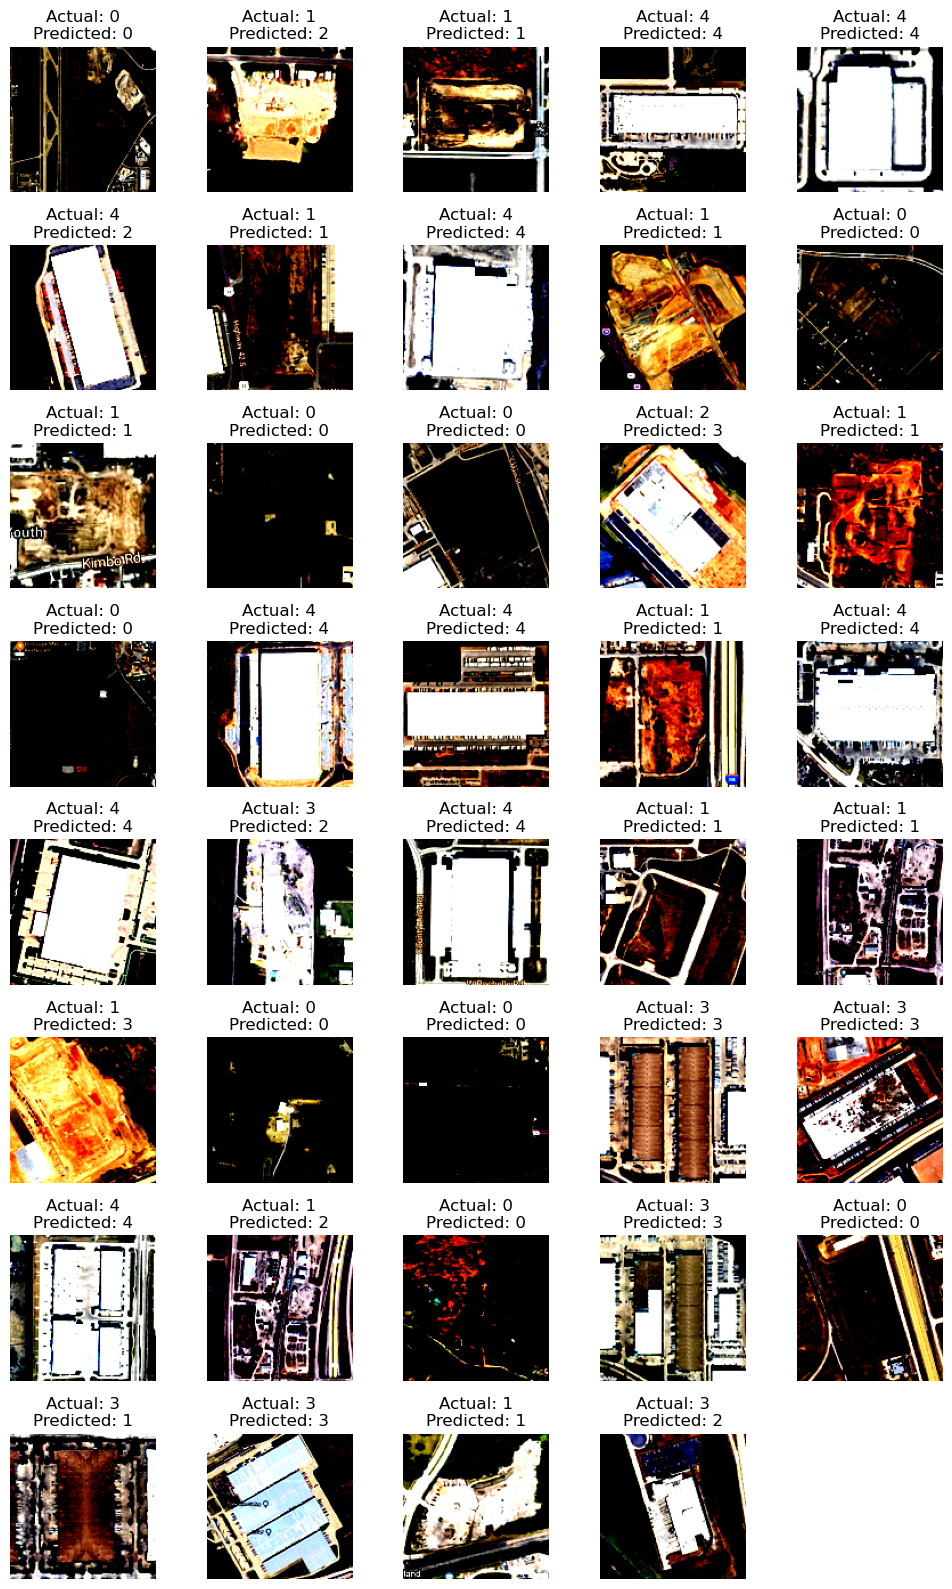

In [6]:
all_images = []
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_images.extend(images.cpu()) 
        all_labels.extend(labels.cpu().numpy()) 
        all_preds.extend(predicted.cpu().numpy()) 

def plot_images(images, true_labels, pred_labels):

    num_images = len(images)

    num_cols = 5
    num_rows = num_images // num_cols + (num_images % num_cols > 0) 

    plt.figure(figsize=(2 * num_cols, 2 * num_rows)) 

    for idx in range(num_images):
        plt.subplot(num_rows, num_cols, idx + 1)
        img = images[idx].permute(1, 2, 0) 
        plt.imshow(img, cmap='gray') if img.shape[2] == 1 else plt.imshow(img)
        plt.title(f'Actual: {true_labels[idx]}\nPredicted: {pred_labels[idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(all_images, all_labels, all_preds)